In [1]:
from transformers import AutoTokenizer, LongformerForSequenceClassification, pipeline
import pandas as pd
import torch
from tqdm import tqdm
tqdm.pandas()

In [2]:
summary = "Here is an essay about economics. It is really interesting and I like to write about economics. Economics is the best in the whole world ever."
source = "Economics is the study of money. Money is fun but also scary. /n Economics is fun!"

In [3]:
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
wording_model = LongformerForSequenceClassification.from_pretrained('tiedaar/longformer-wording-global', num_labels=1).to('cuda')
content_model = LongformerForSequenceClassification.from_pretrained('tiedaar/longformer-content-global', num_labels=1).to('cuda')

In [4]:
def inference(summary, source, model):
    combined = summary + '</s>' + source
    combined = combined.replace('\xa0', '')
    context = tokenizer(combined)
    sep_index = context['input_ids'].index(2)
    context['global_attention_mask'] = [1]*(sep_index + 1) + [0]*(len(context['input_ids'])-(sep_index + 1))
    inputs = {}
    for key in context:
        inputs[key] = torch.tensor([context[key]]).to('cuda')
    return float(model(**inputs)['logits'][0][0])

In [5]:
DATA = '../results/'
summaries_df = pd.read_csv(DATA + 'LT_corrected_final_summaries_scored.csv', index_col=0).reset_index()
print(summaries_df.columns)
test_df = summaries_df[summaries_df['test-train']=='test'][['index', 'source_text', 'content_pca', 'paraphrase_pca',
                                                           'text', 'source', 'orig_overall_score', 'orig_readability_score', 'correct_text', 'corrected_overall',
                                                           'correct_readability_score', 'note', 'LT_corrected_text',
                                                           'LT_R2_corrected_text']]

Index(['index', 'Row.names', 'filename', 'filename_clean', 'source_text',
       'Main.Point', 'Details', 'Cohesion', 'Objective.Language',
       'Wording.Para', 'Lang..Bey..ST', 'Summ..Length', 'content_pca',
       'paraphrase_pca', 'text', 'source_text_clean',
       'source_text_filename_clean', 'source', 'content_global_pred',
       'wording_global_pred', 'test-train', 'orig_overall_score',
       'orig_readability_score', 'correct_text', 'corrected_overall',
       'correct_readability_score', 'Unnamed: 26', 'note', 'LT_corrected_text',
       'LT_R2_corrected_text'],
      dtype='object')


In [6]:
test_df.loc[:,'content_global_pred'] = test_df.progress_apply(lambda row: inference(row['text'], row['source'], content_model), axis=1)
test_df.loc[:,'wording_global_pred'] = test_df.progress_apply(lambda row: inference(row['text'], row['source'], wording_model), axis=1)

100%|██████████| 703/703 [00:47<00:00, 14.87it/s]


In [7]:
test_df.loc[:,'content_corrected_pred'] = test_df.progress_apply(lambda row: inference(row['LT_R2_corrected_text'], row['source'], content_model), axis=1)
test_df.loc[:,'wording_corrected_pred'] = test_df.progress_apply(lambda row: inference(row['LT_R2_corrected_text'], row['source'], wording_model), axis=1)

100%|██████████| 703/703 [00:47<00:00, 14.94it/s]


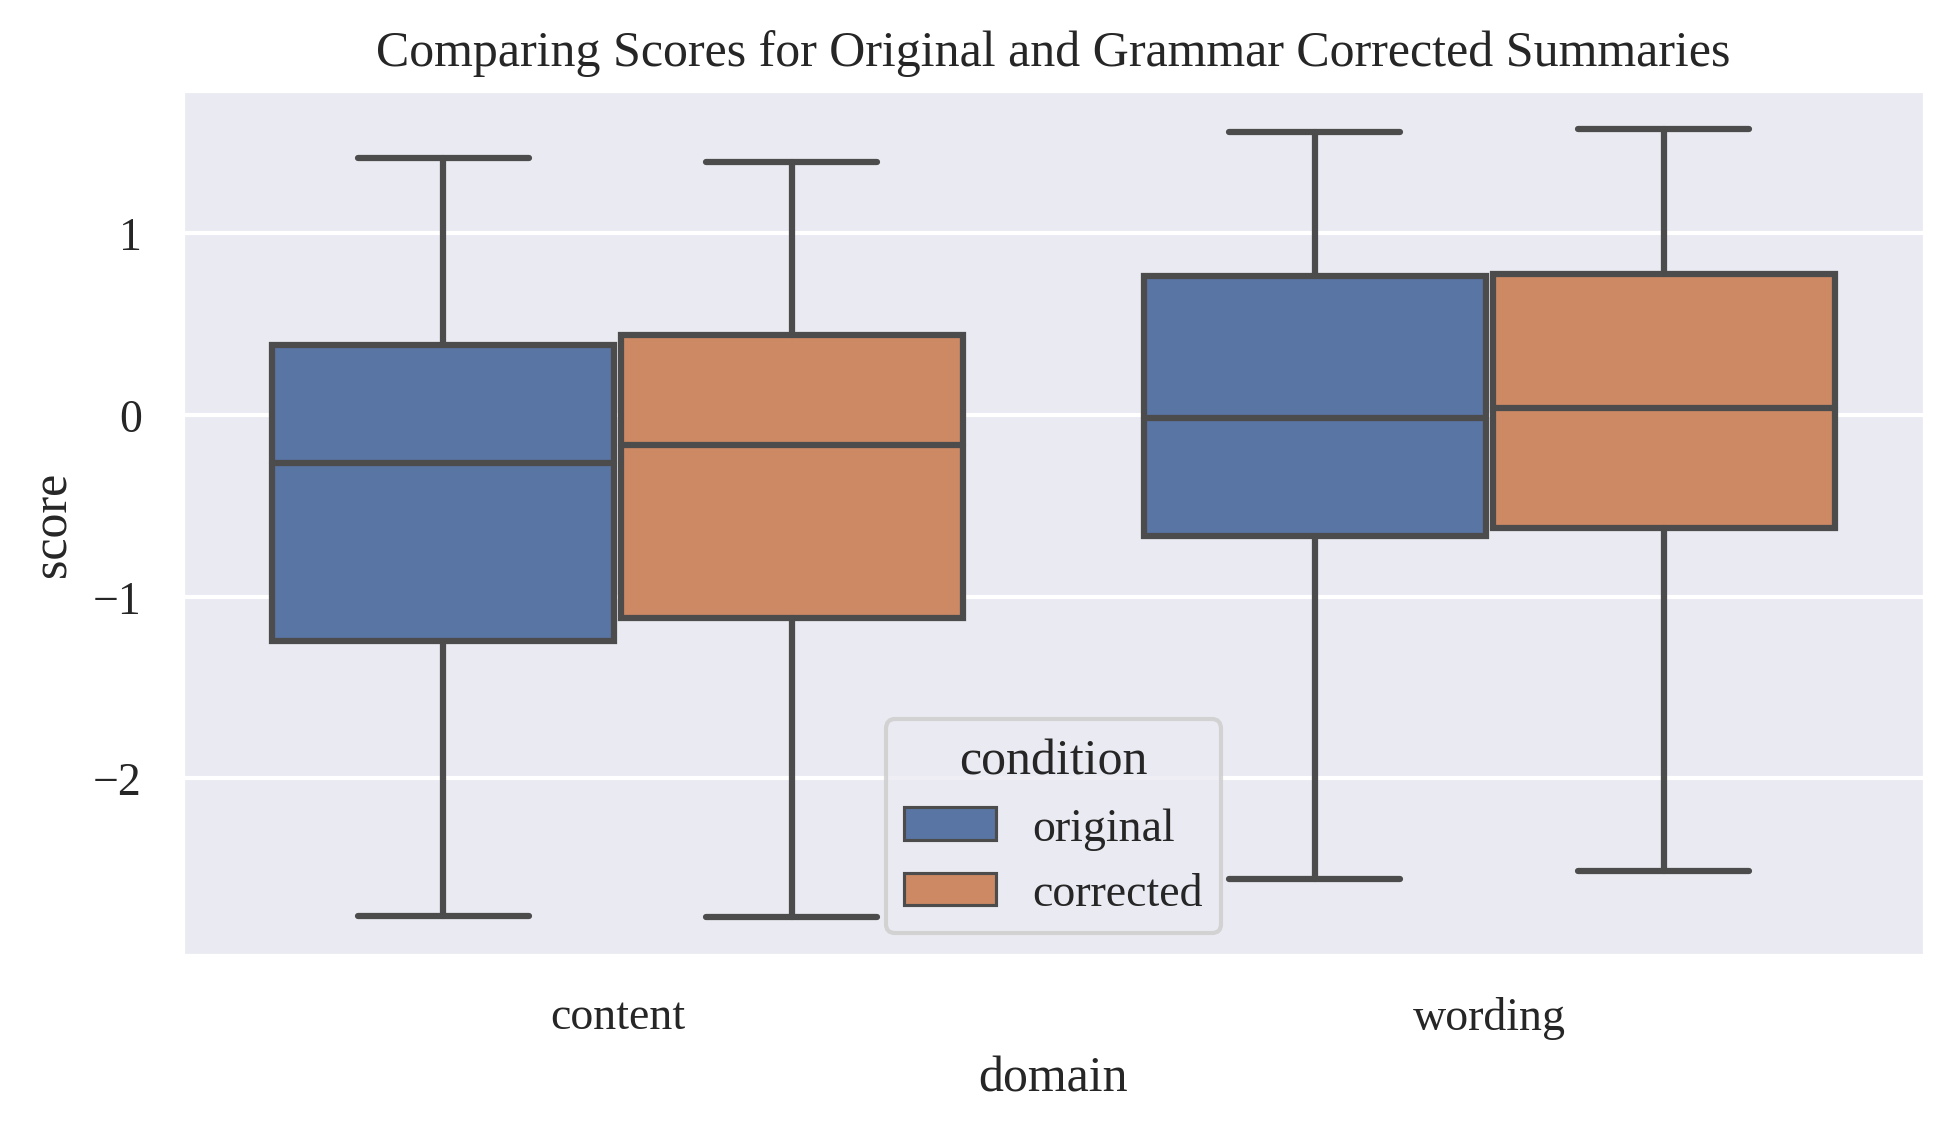

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(font='Liberation Serif',
              rc={'figure.figsize': (7.5,3.75),
                  'font.size': 11,
                  'figure.dpi': 300,
                 })

plot_df = test_df[['index', 'content_global_pred', 'content_corrected_pred', 
                   'wording_global_pred', 'wording_corrected_pred']]

plot_df = pd.melt(plot_df, 
        id_vars=['index'], 
        value_vars=['content_global_pred', 'content_corrected_pred', 'wording_global_pred', 'wording_corrected_pred'], 
        var_name='condition', 
        value_name='score')
plot_df['domain'] = plot_df['condition'].apply(lambda x: x.split('_')[0])
plot_df['condition'] = plot_df['condition'].apply(lambda x: '_'.join(x.split('_')[1:]))

plot_df['condition'] = plot_df['condition'].apply(lambda x: 'original' if x == 'global_pred' else 'corrected')

g = sns.boxplot(plot_df, x='domain', y='score', hue='condition')
plt.title('Comparing Scores for Original and Grammar Corrected Summaries')
plt.show(g)


In [63]:
test_df[['content_global_pred', 'content_corrected_pred', 'wording_global_pred', 'wording_corrected_pred',
        'content_pca', 'paraphrase_pca']].corr()

,content_global_pred,content_corrected_pred,wording_global_pred,wording_corrected_pred,content_pca,paraphrase_pca
content_global_pred,1.000000,0.986652,0.724430,0.705036,0.895879,0.682699
content_corrected_pred,0.986652,1.000000,0.702316,0.691719,0.887841,0.663746
wording_global_pred,0.724430,0.702316,1.000000,0.987450,0.679925,0.832400
wording_corrected_pred,0.705036,0.691719,0.987450,1.000000,0.661849,0.828951
content_pca,0.895879,0.887841,0.679925,0.661849,1.000000,0.710421
paraphrase_pca,0.682699,0.663746,0.832400,0.828951,0.710421,1.000000


In [14]:
from scipy.stats import ttest_rel
test_df['content_diff'] = test_df['content_global_pred'] - test_df['content_corrected_pred']
test_df['wording_diff']= test_df['wording_global_pred']- test_df['wording_corrected_pred']
print(test_df['wording_diff'].mean())
print(test_df['wording_diff'].std())


print(ttest_rel(test_df['content_global_pred'], test_df['content_corrected_pred']))
print(ttest_rel(test_df['wording_global_pred'], test_df['wording_corrected_pred']))

-0.037892488571139554
0.1377504192651704
TtestResult(statistic=-13.953526565171636, pvalue=3.1122629419455845e-39, df=702)
TtestResult(statistic=-7.293531474265746, pvalue=8.172893489769482e-13, df=702)


In [11]:
print(test_df.columns)
for i in ['content_global_pred', 'content_corrected_pred', 'wording_global_pred', 'wording_corrected_pred']:
    print(i)
    print(test_df[i].mean())
    print(test_df[i].std())
    print(len(test_df))

Index(['index', 'source_text', 'content_pca', 'paraphrase_pca', 'text',
       'source', 'orig_overall_score', 'orig_readability_score',
       'correct_text', 'corrected_overall', 'correct_readability_score',
       'note', 'LT_corrected_text', 'LT_R2_corrected_text',
       'content_global_pred', 'wording_global_pred', 'content_corrected_pred',
       'wording_corrected_pred'],
      dtype='object')
content_global_pred
-0.4371285555009223
0.9854044285392964
703
content_corrected_pred
-0.35256518928034714
0.980649158947441
703
wording_global_pred
-0.013663147719229862
0.8699287520371358
703
wording_corrected_pred
0.02422934085190969
0.8490489708054311
703
